In [1]:
import matplotlib.pyplot as plt
from pymongo import MongoClient
from db_load import *
from datetime import datetime
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta

from scipy import stats

In [2]:
client = get_client()
ad_vs_ent, ad_vs_ent_dist, degree_dist, coredb, balancesdb, sccdb = get_gold_collections(client)

In [3]:
advsent = [i for i in ad_vs_ent.find({})]
advsent_dist = [i for i in ad_vs_ent_dist.find({})]
degreedist = [i for i in degree_dist.find({})]
core = [i for i in coredb.find({})]
balances = [i for i in balancesdb.find({})]
scc = [i for i in sccdb.find({})]

all_arr = [advsent, advsent_dist, degreedist, core, balances, scc]

## Addresses and Entities

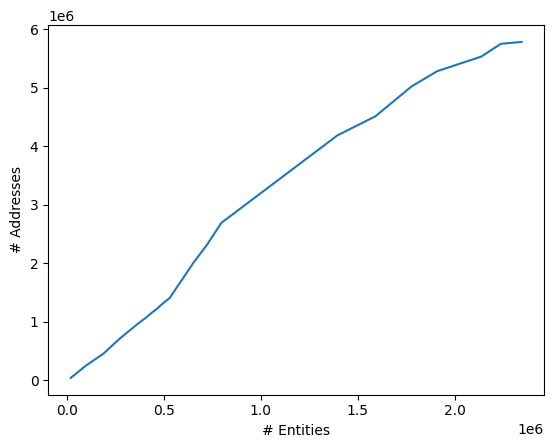

In [110]:
x = [i["no_ent"] for i in advsent]
y = [i["no_addr"] for i in advsent]

plt.plot(x, y)
plt.ylabel("# Addresses")
plt.xlabel("# Entities")
plt.show()

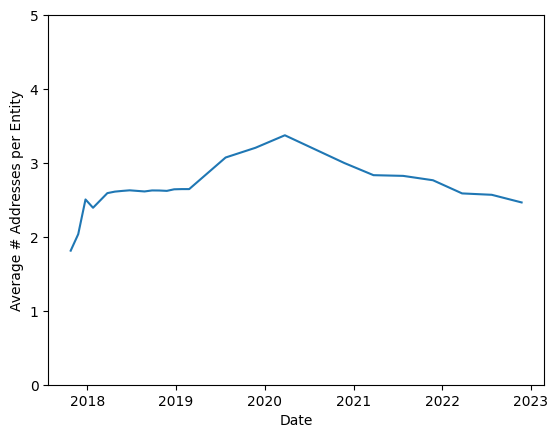

In [4]:
xdate = [datetime.fromtimestamp(i["timestamp"]) for i in advsent]
y = [i["no_addr"]/i["no_ent"] for i in advsent]

plt.plot(xdate, y)
plt.ylim(0,5)
plt.xlabel("Date")
plt.ylabel("Average # Addresses per Entity")
plt.show()

## core perihpery

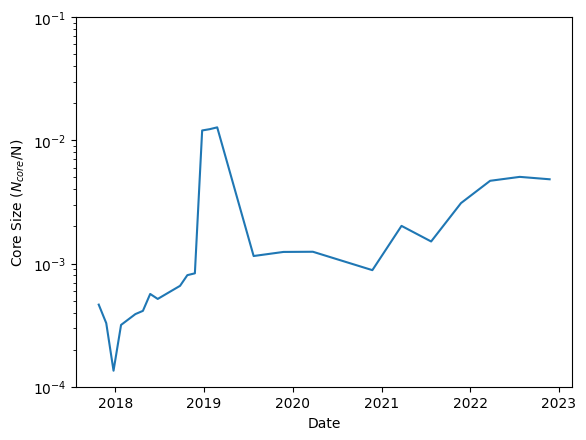

In [11]:
xdate = [datetime.fromtimestamp(i["timestamp"]) for i in core]
coresize = np.array([i["core_length"] for i in core] )
ents = np.array([i["no_ent"] for i in advsent])

plt.plot(xdate, coresize/ents)
plt.xlabel("Date")
plt.ylabel("Core Size ($N_{core}$/N)")
plt.yscale("log")
plt.ylim( (pow(10,-4),pow(10,-1)) )
plt.show()

Scc

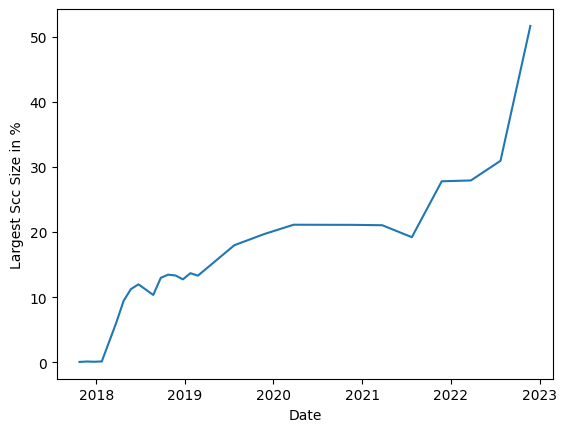

In [4]:
xdate = [datetime.fromtimestamp(i["timestamp"]) for i in scc]
sccs = np.array([i["scc_size"] for i in scc] )
ents = np.array([i["no_ent"] for i in advsent])

plt.plot(xdate, sccs/ents * 100)
plt.xlabel("Date")
plt.ylabel("Largest Scc Size in %")
plt.show()

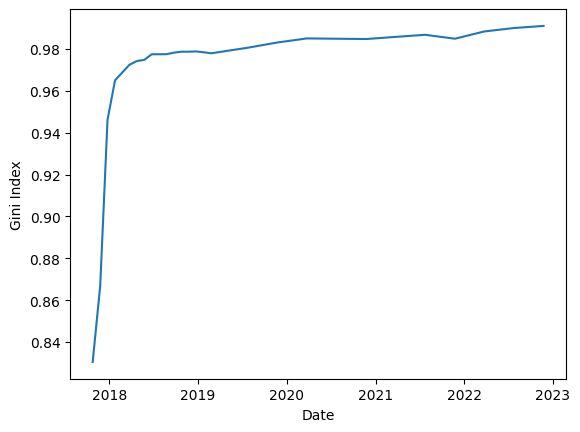

In [123]:
xdate = [datetime.fromtimestamp(i["timestamp"]) for i in balances]
y = np.array([i["gini_index"] for i in balances] )

plt.plot(xdate, y)
plt.xlabel("Date")
plt.ylabel("Gini Index")
plt.show()


## Gini Index

# Plot Data

### Average address per entity number

## Wealth distribution
### Gini Index 